In [1]:
import sys

if ".." not in sys.path:
    sys.path.append("..")

In [2]:
import pickle 

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import cobra

from pprint import pp
from molmass import Formula
from cobra.io import read_sbml_model
from experiments.fast_dFBA import ConstantBounds
from utils.cobra_utils import get_or_create_exchange
from parameters.drawdown import *
from plotting.diagnostic import uptakes_and_secretions, plot_pathway, plot_metabolite_fluxes

In [3]:
MODEL_FILE = "../model/Rpom_05.xml"
BIOMASS_ID = "Rpom_hwa_biomass"
DATA_FILE = "../data/clean/CUE2/dFBA.pkl"


# Load and set up model
model = read_sbml_model(MODEL_FILE)

# Set maintenance to 25 mmol/gDW/h
atpm = model.reactions.get_by_id("ATPM")
atpm.bounds = (25, 25)

ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Load omics data
rna_rel = pd.read_csv("../data/clean/omics/rna-rel.csv")
rna_abs = pd.read_csv("../data/clean/omics/rna-abs.csv")
prot = pd.read_csv("../data/clean/omics/prot.csv")

# Convert reaction_ids column to list
for sheet in [rna_rel, rna_abs, prot]:
    sheet["reaction_ids"] = sheet["reaction_ids"].apply(lambda x: x.split(", ") if isinstance(x, str) else None)

https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http

In [17]:
prot

,Rank,gene_callers_id,DSS3_ac_mean_abund,DSS3_glc_mean_abund,DSS3_late_mean_abund,DSS3_early_mean_abund,DSS3_ac_v_DSS3_glc_FOLD_CHANGE_prot,DSS3_ac_v_DSS3_late_FOLD_CHANGE_prot,DSS3_ac_v_DSS3_early_FOLD_CHANGE_prot,DSS3_glc_v_DSS3_late_FOLD_CHANGE_prot,...,DSS3_glc_v_DSS3_early_Tukey_HSD_adjusted_p,DSS3_late_v_DSS3_early_Tukey_HSD_adjusted_p,SPO_ID (ACCESSION),KOfam (ACCESSION),KEGG_Module,COG20_FUNCTION,n_matches,frame_id,n_reactions,reaction_ids
0,1,476,0.000023,0.000040,0.000006,0.000006,-0.788498,1.999999,1.999999,2.788497,...,NaN,NaN,SPO0476,K06162,NaN,Alpha-D-ribose 1-methylphosphonate 5-triphosph...,1,SPO_RS02400,3.0,"[RXN-17955, RXN-17958, RXN0-6733]"
1,2,231,0.000035,0.000001,0.000015,0.000004,4.696130,1.169927,3.169923,-3.526203,...,NaN,NaN,SPO0233,K03719,NaN,"DNA-binding transcriptional regulator, Lrp fam...",1,SPO_RS01190,0.0,None
2,3,384,0.000011,0.000006,0.000003,0.000003,0.877139,1.999997,1.999997,1.122859,...,NaN,NaN,SPO0384,NaN,NaN,Uncharacterized conserved protein containing a...,1,SPO_RS22095,0.0,None
3,4,3705,0.000007,0.000014,0.000007,0.000007,-0.921748,0.000000,0.000000,0.921748,...,NaN,NaN,SPO3704,K15546,NaN,Shikimate kinase (AroK) (PDB:1E6C)!!!Archaeal ...,1,SPO_RS18790,0.0,None
4,5,1365,0.000008,0.000012,0.000008,0.000008,-0.544543,0.000000,0.000000,0.544543,...,NaN,NaN,SPO1363,K00796,"Tetrahydrofolate biosynthesis, GTP => THF",Dihydropteroate synthase (FolP) (PDB:1AD1),1,SPO_RS06950,1.0,[H2PTEROATESYNTH-RXN]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4337,4338,4337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,SPOA0441,NaN,NaN,NaN,1,SPO_RS22060,0.0,None
4338,4339,4338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,SPOA0442,NaN,NaN,NaN,0,NaN,NaN,None
4339,4340,4339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,SPOA0443,NaN,NaN,NaN,1,SPO_RS22065,0.0,None
4340,4341,4341,NaN,NaN,NaN,0.000004,NaN,NaN,NaN,NaN,...,NaN,NaN,SPOA0445,K09826,NaN,Fe2+ or Zn2+ uptake regulation protein Fur/Zur...,1,SPO_RS22075,0.0,None


In [4]:
sheet["reaction_ids"].isna().value_counts()

reaction_ids
True     3324
False    1018
Name: count, dtype: int64

In [5]:
# Get fluxes when running on glucose, acetate
with model:
    ex_glc.bounds = (-10, 0)
    sol_glc = model.optimize()
    mu_glc = sol_glc.objective_value
    model.summary()
    print(f"Glucose growth: {sol_glc.objective_value:.2f}")

with model:
    ex_ace.bounds = (-10, 0)
    sol_ace = model.optimize()
    mu_ace = sol_ace.objective_value
    model.summary()
    print(f"Acetate growth: {sol_ace.objective_value:.2f}")

model_fc = ((sol_ace.fluxes) / mu_ace) / ((sol_glc.fluxes) / mu_glc)

# Get fold-changes, taking the absolute value as we're interested in the magnitude of flux,
# and not necessarily the direction
# (Although maybe direction-switching fluxes are interesting?)
model_abs_fc = (np.abs(sol_ace.fluxes) / mu_ace) / ((np.abs(sol_glc.fluxes) / mu_glc))

model_diff = np.abs(sol_ace.fluxes / mu_ace) - np.abs(sol_glc.fluxes / mu_glc)


Glucose growth: 0.61
Acetate growth: 0.13


{'whiskers': [<matplotlib.lines.Line2D at 0x7e225c098fb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7e225c099580>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e225c07c590>],
 'medians': [<matplotlib.lines.Line2D at 0x7e225c099b80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7e225c099e50>],
 'means': []}

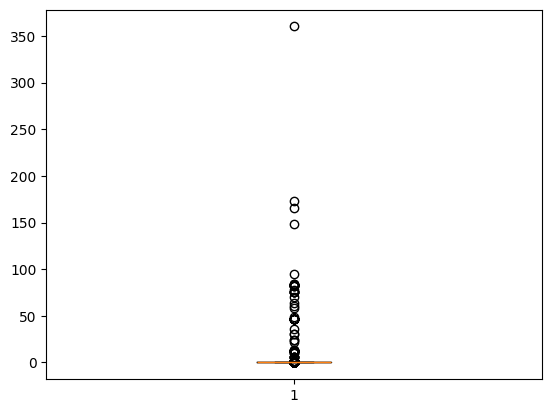

In [6]:
fig, ax = plt.subplots()
ax.boxplot(abs(model_diff))

# ax.set_yscale("log")

In [ ]:
# For each reaction in the flux vectors, get the max of the corresponding RNA levels

rna_max = []
rna_max_fc = []  # ace / glc
for rxnid in sol_glc.fluxes.index:
    stem = model.reactions.get_by_id(rxnid).notes.get("stem", rxnid)

    matching = [stem in ids if isinstance(ids, list) else False for ids in rna_abs["reaction_ids"]]
    if sum(matching) == 0:
        rna_max.append(None)
        rna_max_fc.append(None)
    else:
        rna_max.append(rna_abs[matching]["DSS3_glc_mean_abund"].max())
        rna_max_fc.append(rna_abs[matching]["DSS3_ac_mean_abund"].max() / rna_abs[matching]["DSS3_glc_mean_abund"].max())

In [8]:
# There are two genes with zero expression in glucose (and acetate),
# namely SPO_tRNA-Ile-3	and SPO_tRNA-Ala-4.
# Remove these?
rna_abs[rna_abs["DSS3_glc_mean_abund"] == 0]

,Rank,gene_callers_id,DSS3_ac_mean_abund,DSS3_glc_mean_abund,DSS3_late_mean_abund,DSS3_early_mean_abund,DSS3_ac_v_DSS3_glc_FOLD_CHANGE_rna,DSS3_ac_v_DSS3_late_FOLD_CHANGE_rna,DSS3_ac_v_DSS3_early_FOLD_CHANGE_rna,DSS3_glc_v_DSS3_late_FOLD_CHANGE_rna,...,DSS3_glc_v_DSS3_early_Tukey_HSD_adjusted_p,DSS3_late_v_DSS3_early_Tukey_HSD_adjusted_p,SPO_ID (ACCESSION),KOfam (ACCESSION),KEGG_Module,COG20_FUNCTION,n_matches,frame_id,n_reactions,reaction_ids
4335,4336,3802,0.0,0.0,0.0,27050.933786,NaN,NaN,NaN,NaN,...,NaN,NaN,SPO_tRNA-Ile-3,NaN,NaN,NaN,1,SPO_RS19280,0.0,None
4336,4337,3801,0.0,0.0,0.0,54978.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,SPO_tRNA-Ala-4,NaN,NaN,NaN,1,SPO_RS19275,0.0,None


In [10]:
import plotly.express as px

df = pd.DataFrame(
    [
        {
            "Reaction ID": rxnid,
            "Model flux": abs(flux),
            "RNA": rna
        }
        for (rxnid, flux), rna in zip(sol_glc.fluxes.items(), rna_max)
    ])

fig = px.scatter(
    df, x="Model flux", y="RNA",
    hover_data='Reaction ID',
    # log_x=True,
    # log_y=True
)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Run many samples at optimality using optgp
from cobra.sampling import OptGPSampler

optgp = OptGPSampler(model, processes=4)

# Get fluxes when running on glucose, acetate
with model:
    ex_glc.bounds = (-10, 0)
    mu_glc = model.slim_optimize()

    # Enforce optimality
    model.reactions.get_by_id(BIOMASS_ID).bounds = (0.99*mu_glc, 1000)

    sols_glc = optgp.sample(10)
    assert sum(optgp.validate(sols_glc) == "v") == 100

with model:
    ex_ace.bounds = (-10, 0)
    mu_ace = model.slim_optimize()

    # Enforce optimality
    model.reactions.get_by_id(BIOMASS_ID).bounds = (0.99*mu_ace, 1000)

    sols_ace = optgp.sample(10)
    assert sum(optgp.validate(sols_ace) == "v") == 100

# with model:
#     ex_ace.bounds = (-10, 0)
#     sol_ace = model.optimize()
#     mu_ace = sol_ace.objective_value
#     model.summary()
#     print(f"Acetate growth: {sol_ace.objective_value:.2f}")

# model_fc = ((sol_ace.fluxes) / mu_ace) / ((sol_glc.fluxes) / mu_glc)

# # Get fold-changes, taking the absolute value as we're interested in the magnitude of flux,
# # and not necessarily the direction
# # (Although maybe direction-switching fluxes are interesting?)
# model_abs_fc = (np.abs(sol_ace.fluxes) / mu_ace) / ((np.abs(sol_glc.fluxes) / mu_glc))

# model_diff = np.abs(sol_ace.fluxes / mu_ace) - np.abs(sol_glc.fluxes / mu_glc)


/home/mica/.pyenv/versions/3.12.1/envs/rpom/lib/python3.12/site-packages/cobra/sampling/optgp.py:126: RuntimeWarning:

Mean of empty slice.

/home/mica/.pyenv/versions/3.12.1/envs/rpom/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide



ValueError: high <= 0

In [ ]:
import plotly.express as px

df = pd.DataFrame(
    [
        {
            "Reaction ID": rxnid,
            "Model fold-change (ace/glc)": fc,
            "RNA fold-change (ace/glc)": rna_fc
        }
        for (rxnid, fc), rna_fc in zip(model_abs_fc.items(), rna_max_fc)
        if (not np.isnan(fc)
            and not np.isinf(fc)
            and rna_fc is not None
            and not np.isnan(rna_fc)
            and not np.isinf(rna_fc))
    ])

fig = px.scatter(
    df, x="Model fold-change (ace/glc)", y="RNA fold-change (ace/glc)",
    hover_data='Reaction ID',
    # log_x=True,
    # log_y=True
)
fig.show()

fig.write_html("transcriptome_vs_flux.html")

In [ ]:
model.reactions.get_by_id("RXN-8957")

Reaction identifier,RXN-8957
Name,RXN-8957
Memory address,0x7f15fdd9ea50
Stoichiometry,CARBON-DIOXIDE[c] + CROTONYL-COA[c] + NADPH[c] --> CPD-9406[c] + NADP[c] CO2 + crotonyl-CoA + NADPH --> (2S)-ethylmalonyl-CoA + NADP+
GPR,G1G48-377
Lower bound,0.0
Upper bound,1000.0


In [ ]:
model.reactions.get_by_id("ACETATE--COA-LIGASE-RXN")

Reaction identifier,ACETATE--COA-LIGASE-RXN
Name,ACETATE--COA-LIGASE-RXN
Memory address,0x7f15fe5c6a80
Stoichiometry,ACET[c] + ATP[c] + CO-A[c] --> ACETYL-COA[c] + AMP[c] + PPI[c] acetate + ATP + coenzyme A --> acetyl-CoA + AMP + diphosphate
GPR,G1G48-4366 or G1G48-1850 or G1G48-1997 or G1G48-2841
Lower bound,0.0
Upper bound,1000.0


In [ ]:
# acs is always kept online?
# RXN-8957 is ethylmalonyl-CoA pathway, specifically crotonyl-CoA + CO2 + NADPH -> (2S)-ethylmalonyl-CoA + NADP
    # (Major NADP generating step according to FBA)

In [ ]:
# Get all reactions (stems) in the ethylmalonyl-CoA pathway
ethCoA_rxns = set([rxn.notes["stem"] for rxn in model.reactions if "PWY-5741" in rxn.notes.get("pathways", [])])

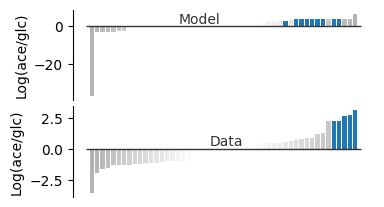

In [ ]:
sorted_model_log_fc = df.sort_values("Model fold-change (ace/glc)", ascending=True).dropna()
sorted_data_log_fc = df.sort_values("RNA fold-change (ace/glc)", ascending=True).dropna()

# Drop zeros to avoid bad logs
sorted_model_log_fc = sorted_model_log_fc[sorted_model_log_fc["Model fold-change (ace/glc)"] != 0]
sorted_data_log_fc = sorted_data_log_fc[sorted_data_log_fc["RNA fold-change (ace/glc)"] != 0]

# Take logs
sorted_model_log_fc["Model fold-change (ace/glc)"] = np.log(sorted_model_log_fc["Model fold-change (ace/glc)"])
sorted_data_log_fc["RNA fold-change (ace/glc)"] = np.log(sorted_data_log_fc["RNA fold-change (ace/glc)"])

fig, axs = plt.subplots(2, 1)

N = 20
GAP_SIZE = 10

colors = [str(c) for c in np.linspace(0.7, 1, N)]
for i, rxn in enumerate(sorted_model_log_fc["Reaction ID"].head(N)):
    if rxn in ethCoA_rxns:
        colors[i] = "tab:blue"
axs[0].bar(np.arange(N),
           sorted_model_log_fc["Model fold-change (ace/glc)"].head(N),
           color = colors,
           edgecolor=[str(c) for c in np.linspace(0.5, 0.8, N)],
           lw=0)

colors = [str(c) for c in np.linspace(1, 0.7, N)]
for i, rxn in enumerate(sorted_model_log_fc["Reaction ID"].tail(N)):
    if rxn in ethCoA_rxns:
        colors[i] = "tab:blue"
axs[0].bar(np.arange(N + GAP_SIZE, GAP_SIZE + 2 * N),
           sorted_model_log_fc["Model fold-change (ace/glc)"].tail(N),
           color = colors,
           edgecolor=[str(c) for c in np.linspace(0.8, 0.5, N)],
           lw=0)

colors = [str(c) for c in np.linspace(0.7, 1, N)]
for i, rxn in enumerate(sorted_data_log_fc["Reaction ID"].head(N)):
    if rxn in ethCoA_rxns:
        colors[i] = "tab:blue"
axs[1].bar(np.arange(N),
           sorted_data_log_fc["RNA fold-change (ace/glc)"].head(N),
           color=[
               "tab:blue" if rxn in ethCoA_rxns else str(np.linspace(0.7, 1, N)[i])
               for i, rxn in enumerate(sorted_data_log_fc["Reaction ID"].head(N))
           ],
           edgecolor=[str(c) for c in np.linspace(0.5, 0.8, N)],
           lw=0)

colors = [str(c) for c in np.linspace(1, 0.7, N)]
for i, rxn in enumerate(sorted_data_log_fc["Reaction ID"].tail(N)):
    if rxn in ethCoA_rxns:
        colors[i] = "tab:blue"
axs[1].bar(np.arange(N + GAP_SIZE, GAP_SIZE + 2 * N),
           sorted_data_log_fc["RNA fold-change (ace/glc)"].tail(N),
           color=[
               "tab:blue" if rxn in ethCoA_rxns else str(np.linspace(1, 0.7, N)[i])
               for i, rxn in enumerate(sorted_data_log_fc["Reaction ID"].tail(N))
           ],
           edgecolor=[str(c) for c in np.linspace(0.8, 0.5, N)],
           lw=0)

# Baselines
axs[0].hlines(0, -1, 2*N + GAP_SIZE, color="0.2", linewidth=1)
axs[1].hlines(0, -1, 2*N + GAP_SIZE, color="0.2", linewidth=1)

# Hide spines, x ticks
for ax in axs:
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.set_xticks([])

# ax.set_xlim(0, 3 * N + 1)
# ax.set_ylim(sorted_model_log_fc["Model fold-change (ace/glc)"].min(),
            # sorted_model_log_fc["Model fold-change (ace/glc)"].max())

axs[0].text(N, 0, "Model", ha="center", va="bottom", color="0.2", fontsize=10)
axs[1].text(N + 5, 0, "Data", ha="center", va="bottom", color="0.2", fontsize=10)

axs[0].set_ylabel("Log(ace/glc)", fontsize=10)
axs[1].set_ylabel("Log(ace/glc)", fontsize=10)

fig.subplots_adjust(hspace=0.1)
fig.tight_layout()
fig.set_size_inches(3.5, 2)
fig.savefig("ace_vs_glc__omics.svg")

In [ ]:
sol_glc[[rxn for rxn in ethCoA_rxns if rxn in sol_glc.fluxes.index]]

RXN-9530                         0.000000
RXN-16391                        0.815883
RXN-17779                        0.000000
RXN-8957                         0.815883
ACETYL-COA-ACETYLTRANSFER-RXN    1.485362
RXN-17775                        0.000000
RXN-12560                        0.000000
RXN-8961                         0.815883
RXN-8959                         0.815883
MALATE--COA-LIGASE-RXN          -0.816364
RXN-9534                         0.000000
RXN-18384                        0.000000
RXN-5901                         0.000000
RXN-9515                         0.000000
RXN-8958                         0.815883
RXN-9521                         0.000000
RXN-9538                         0.000000
RXN-9526                         0.000000
MALYL-COA-LYASE-RXN              0.816364
METHYLMALONYL-COA-EPIM-RXN      -0.815883
RXN-17783                        0.000000
RXN-9542                         0.000000
Name: fluxes, dtype: float64

In [ ]:
sorted_model_log_fc.head(20)

,Reaction ID,Model fold-change (ace/glc),RNA fold-change (ace/glc)
406,PPENTOMUT-RXN,-3.749647e+01,0.962287
764,SHIKIMATE-5-DEHYDROGENASE-RXN,-3.208440e+00,0.477055
221,F16ALDOLASE-RXN,-2.870395e+00,0.838535
397,PHOSGLYPHOS-RXN,-2.803928e+00,0.662316
230,GAPOXNPHOSPHN-RXN,-2.803928e+00,0.143372
787,TRIOSEPISOMERIZATION-RXN,-2.686139e+00,0.482255
393,PGLUCISOM-RXN,-2.493505e+00,0.204423
325,L-GLN-FRUCT-6-P-AMINOTRANS-RXN-FRUCTOSE-6P/GLN...,-2.563678e-01,0.317359
54,3PGAREARR-RXN,-1.976178e-01,0.823227
38,2PGADEHYDRAT-RXN,-1.976178e-01,0.476817


In [ ]:
len(model.genes)

1250

In [ ]:
sorted_data_log_fc.head(20)

,Reaction ID,Model fold-change (ace/glc),RNA fold-change (ace/glc)
244,GLUCOKIN-RXN-GLC/ATP//D-glucopyranose-6-phosph...,0.000000,-3.529044
242,GLUCOKIN-RXN,0.000000,-3.529044
243,GLUCOKIN-RXN-ALPHA-GLUCOSE/ATP//D-glucopyranos...,0.000000,-3.529044
817,XYLULOKIN-RXN,0.000000,-3.280038
239,GLUCISOM-RXN,0.000000,-2.954926
815,XYLISOM-RXN-BETA-D-XYLOSE//D-XYLULOSE.26.,0.000000,-2.954926
816,XYLISOM-RXN-XYLOSE//D-XYLULOSE.19.,0.000000,-2.954926
240,GLUCISOM-RXN-ALPHA-GLUCOSE//CPD-15382.25.,0.000000,-2.954926
241,GLUCISOM-RXN-GLC//CPD-15382.15.,0.000000,-2.954926
814,XYLISOM-RXN,0.000000,-2.954926


In [ ]:
sorted_model_log_fc["Model fold-change (ace/glc)"].head(N)

406   -3.749647e+01
764   -3.208440e+00
221   -2.870395e+00
397   -2.803928e+00
230   -2.803928e+00
787   -2.686139e+00
393   -2.493505e+00
325   -2.563678e-01
54    -1.976178e-01
38    -1.976178e-01
8     -1.962754e-01
184   -1.495160e-11
384   -1.495160e-11
383   -1.495148e-11
40    -1.495148e-11
387   -1.495148e-11
388   -1.495148e-11
386   -1.495148e-11
569   -1.495148e-11
18    -1.495148e-11
Name: Model fold-change (ace/glc), dtype: float64

array([[<Axes: title={'center': 'Model fold-change (ace/glc)'}>,
        <Axes: title={'center': 'RNA fold-change (ace/glc)'}>]],
      dtype=object)

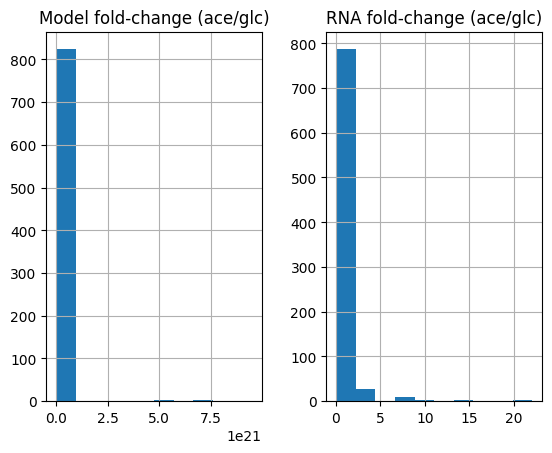

In [ ]:
df.sort_values("Model fold-change (ace/glc)", ascending=True).dropna().hist()

In [ ]:
# Initially, setting arbitary thresholds for change/no change
# TODO: ANOVA (with Bonferroni correction) or something
thresh_upper = 1.5
thresh_lower = 0.5

In [ ]:
df[df["Reaction ID"] == "RXN-8957"]

,Reaction ID,Model fold-change (ace/glc),RNA fold-change (ace/glc)
640,RXN-8957,42.808829,22.05915


In [ ]:
model.reactions.get_by_id("RXN-8957").notes

{'EC Number': '1.3.1.85',
 'Kegg ID': 'R09291',
 'stem': 'RXN-8957',
 'pathways': 'PWY-5741'}

In [ ]:
# Get significant changes
# TODO: use proper statistical tests for rna, figure out what to do with model
rna_sig = np.logical_or(df["RNA fold-change (ace/glc)"] > thresh_upper, df["RNA fold-change (ace/glc)"] < thresh_lower)
model_sig = np.logical_or(df["Model fold-change (ace/glc)"] > thresh_upper, df["Model fold-change (ace/glc)"] < thresh_lower)

df["Category"] = [
    ("-+"[rna]) + "/" + ("-+"[model])
    for rna, model in zip(rna_sig, model_sig)
]
df["Category"].value_counts()

Category
-/+    442
-/-    171
+/+    171
+/-     47
Name: count, dtype: int64

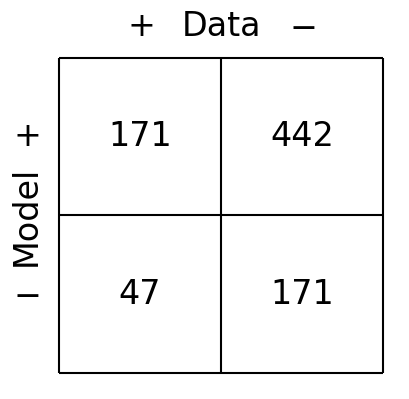

In [ ]:
fig, ax = plt.subplots()

table = df["Category"].value_counts()

# Draw table with value counts
for x, rna_cat in enumerate("+-"):
    for y, model_cat in enumerate("-+"):
        ax.text(x/2 + 0.25,
                y/2 + 0.25,
                str(table[f"{rna_cat}/{model_cat}"]),
                ha="center",
                va="center",
                fontsize=24)
ax.vlines([0, 0.5, 1], 0, 1, colors=["k"])
ax.hlines([0, 0.5, 1], 0, 1, colors=["k"])

# Label sides, categories
LABEL_OFFSET = 0.1
ax.text(-LABEL_OFFSET, 0.5, "Model", ha="center", va="center", rotation=90, fontsize=24)
ax.text(0.5, 1 + LABEL_OFFSET, "Data", ha="center", va="center", fontsize=24)

for i, rna_cat in enumerate("+-"):
    ax.text(i/2 + 0.25, 1 + LABEL_OFFSET, f"${rna_cat}$", ha="center", va="center", fontsize=24)

for i, model_cat in enumerate("-+"):
    ax.text(-LABEL_OFFSET, i/2 + 0.25, f"${model_cat}$", ha="center", va="center", fontsize=24)

# Aesthetics (hide ticks and spines)
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

fig.tight_layout()
fig.set_size_inches(4, 4)


In [ ]:
from ontologize.ontology import build_ontology, get_session

session = get_session()

In [ ]:
from tqdm import tqdm

ontologies = {}
for category in tqdm(("+/+", "+/-", "-/+", "-/-")):
    # Get reactions in category
    reactions = df[df["Category"] == category]

    # Get pathways for each reaction
    rxn_pathways = {
        rxn: (model.reactions.get_by_id(rxn)
              .notes
              .get("pathways", []))
        for rxn in reactions["Reaction ID"].values
    }
    rxn_pathways = {rxn: (pwys.copy() if isinstance(pwys, list) else [pwys])
                    for rxn, pwys in rxn_pathways.items()}

    # Manually curate pathways to improve assignments
    # (e.g., AcCoA ligase belongs to some spurious pathways, so keep only the relevant one)
    if "ACETATE--COA-LIGASE-RXN" in rxn_pathways:
        rxn_pathways["ACETATE--COA-LIGASE-RXN"].remove('PWY-8328')
        rxn_pathways["ACETATE--COA-LIGASE-RXN"].remove('PWY-8303')

    # Build onotology
    ontologies[category] = build_ontology(reactions["Reaction ID"].values,
                                          "Pathway",
                                          property=list(rxn_pathways.values()),
                                          org_id="GCF_000011965",
                                          session=session,
                                          show_progress=False)

for category, ontology in ontologies.items():
    print(f"{category} ======================")
    generations = nx.topological_generations(ontology.graph)
    print(f"Level 1: {next(generations)}")
    print()

100%|██████████| 4/4 [00:58<00:00, 14.55s/it]

+/+ ======================
Level 1: ['Energy-Metabolism', 'Degradation', 'Biosynthesis', 'Super-Pathways', 'Metabolic-Clusters', 'Detoxification']

+/- ======================
Level 1: ['Biosynthesis', 'Energy-Metabolism', 'Degradation', 'Super-Pathways', 'Metabolic-Clusters', 'Detoxification']

-/+ ======================
Level 1: ['Degradation', 'Energy-Metabolism', 'Biosynthesis', 'Super-Pathways', 'Activation-Inactivation-Interconversion', 'Metabolic-Clusters', 'Macromolecule-Modification', 'Glycan-Pathways']

-/- ======================
Level 1: ['Biosynthesis', 'Degradation', 'Energy-Metabolism', 'Activation-Inactivation-Interconversion', 'Super-Pathways', 'Metabolic-Clusters']



In [ ]:
for category, ontology in ontologies.items():
    print(f"{category} ======================")
    print(ontology.to_string(include_leaves=True, colors=True))
    print()

+/+ ======================
Generation of Precursor Metabolites and Energy [Energy-Metabolism] {39 members}
├TCA cycle [TCA-VARIANTS] {6 members}
│└TCA cycle I (prokaryotic) [TCA] {2OXOGLUTARATEDEH-RXN}
├Respiration [Respiration] {RXN0-1132, 2OXOGLUTARATEDEH-RXN}
│├2-oxoglutarate decarboxylation to succinyl-CoA [PWY-5084] {2OXOGLUTARATEDEH-RXN}
│└2-oxoisovalerate decarboxylation to isobutanoyl-CoA [PWY-5046] {RXN0-1132}
├Entner-Doudoroff Pathways [Entner-Duodoroff-Pathways] {8 members}
│├Entner-Doudoroff shunt [ENTNER-DOUDOROFF-PWY] {4OH2OXOGLUTARALDOL-RXN}
│└Entner-Doudoroff pathway I [PWY-8004] {GAPOXNPHOSPHN-RXN}
├Fermentation [Fermentation] {RXN-18446, ACETATEKIN-RXN, RXN-18448, RXN-18447}
│├Amino Acid Fermentation (Stickland reactions) [Amino-Acid-Fermentation] {ACETATEKIN-RXN}
││└L-threonine degradation I [PWY-5437] {ACETATEKIN-RXN}
│├Fermentation to Short-Chain Fatty Acids [Fermentation-to-Acids] {RXN-18446, ACETATEKIN-RXN, RXN-18448, RXN-18447}
││└Fermentation to Acetate [Acetat

/tmp/ipykernel_24349/791418892.py:16: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



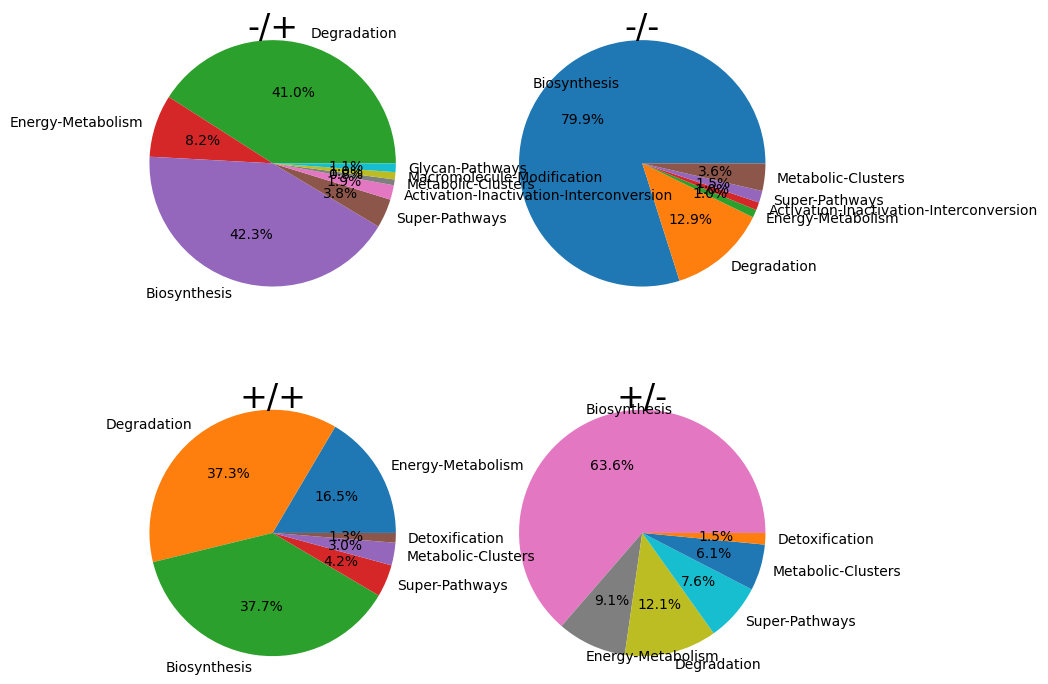

In [ ]:
fig, ax = plt.subplots()

for i, (category, ontology) in enumerate(ontologies.items()):
    x = 3 * (i % 2)
    y = 3 * (i // 2)

    ax.text(x, y + 1.1, category, ha="center", va="center", fontsize=24)

    labels = next(nx.topological_generations(ontology.graph))
    sizes = [len(ontology.graph.nodes[g]["members"]) for g in labels]
    ax.pie(sizes,
           labels=labels,
           center=(x,y),
           autopct='%1.1f%%')

fig.tight_layout()
fig.set_size_inches(4,4)

In [ ]:
import matplotlib

# utility function to convert a name to a color
def name_to_color(name, N = 17):
    theta_1 = (hash(name) % N) / N
    theta_2 = (hash(theta_1) % N) / N
    theta_3 = (hash(theta_2) % N) / N

    h = theta_1
    s = 0.6 + 0.4 * theta_2
    v = 0.5 + 0.4 * theta_3
    return matplotlib.colors.hsv_to_rgb([h,s,v])

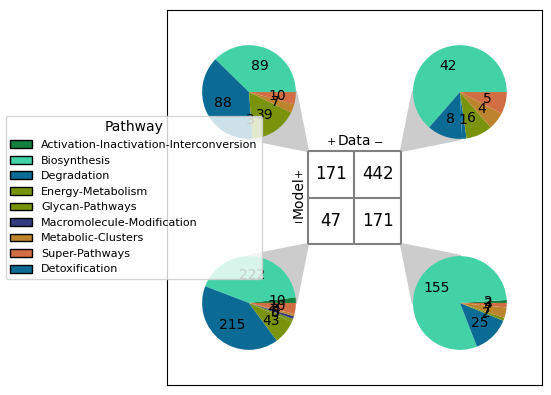

In [ ]:
from matplotlib.patches import Patch, Polygon

fig, ax = plt.subplots()

table = df["Category"].value_counts()

# Draw table with value counts
for x, rna_cat in enumerate("+-"):
    for y, model_cat in enumerate("-+"):
        ax.text(x/2 + 0.25,
                y/2 + 0.25,
                str(table[f"{rna_cat}/{model_cat}"]),
                ha="center",
                va="center",
                fontsize=12)
ax.vlines([0, 0.5, 1], 0, 1, colors=[".5"])
ax.hlines([0, 0.5, 1], 0, 1, colors=[".5"])

# Label sides, categories
LABEL_OFFSET = 0.1
ax.text(-LABEL_OFFSET, 0.5, "Model", ha="center",
        va="center", rotation=90, fontsize=10)
ax.text(0.5, 1 + LABEL_OFFSET, "Data", ha="center", va="center", fontsize=10)

for i, rna_cat in enumerate("+-"):
    ax.text(i/2 + 0.25, 1 + LABEL_OFFSET,
            f"${rna_cat}$", ha="center", va="center", fontsize=8)

for i, model_cat in enumerate("-+"):
    ax.text(-LABEL_OFFSET, i/2 + 0.25,
            f"${model_cat}$", ha="center", va="center", fontsize=8)

# Draw pies for each category ===================================================================
RADIUS = .5
PIE_OFFSET_FACTOR = 2.5

COLOR_N = 20

legend_elements = {}
patches = []

for i, category in enumerate(("-/+", "-/-", "+/+", "+/-")):

    ontology = ontologies[category]

    # Magic formula to get x, y coordinates for the pie, offset from table
    x = (1 + PIE_OFFSET_FACTOR * RADIUS) * \
        ((i % 2)) - (PIE_OFFSET_FACTOR * RADIUS) / 2
    y = (1 + PIE_OFFSET_FACTOR * RADIUS) * \
        ((i // 2)) - (PIE_OFFSET_FACTOR * RADIUS) / 2

    # For debugging
    # ax.text(x, y + RADIUS + 2 * LABEL_OFFSET, category,
    #         ha="center", va="center", fontsize=24)

    # Draw lollipop stem
    # ax.plot([i % 2, x], [i // 2, y], "k", zorder=0, lw=3, solid_capstyle="butt")
    endpoint_1 = np.array([x + RADIUS * (1 - 2 * (i % 2)), y])
    endpoint_2 = np.array([x, y + RADIUS * (1 - 2 * (i//2))])
    patches.append(Polygon([[i % 2, i // 2],
                            endpoint_1,
                            endpoint_2],
                           closed=True,
                           fill=True,
                           edgecolor=".8",
                           facecolor=".8",
                           lw=2))

    labels = list(
        sorted(
            next(
                nx.topological_generations(ontology.graph)
            )
        )
    )
    # labels = list(
    #     sorted(
    #         list(
    #             nx.topological_generations(ontology.graph)
    #         )[1]
    #     )
    # )
    sizes = [len(ontology.graph.nodes[g]["members"]) for g in labels]
    ax.pie(sizes,
           colors=[name_to_color(g, N=COLOR_N) for g in labels],
           frame=True,  # Necessary to show table edges for some reason; turn off manually later
           center=(x, y),
           radius=RADIUS,
           autopct=lambda p: int(np.round((p / 100) * sum(sizes))))  # Show integer counts for now - may be confusing since reactions belong to multiple pathways...

    # Add legend element if not already present
    for g in labels:
        if g not in legend_elements:
            legend_elements[g] = Patch(facecolor=name_to_color(
                g, N=COLOR_N), edgecolor="k", label=g)

ax.add_collection(
    matplotlib.collections.PatchCollection(patches,
                                           match_original=True,
                                           zorder=0
                                           )
)

fig.legend(handles=legend_elements.values(), loc="center left",
           title="Pathway", fontsize=8, title_fontsize=10)

# Set axis limits to ensure visibility
ax.set_xlim(-1.5, 2.5)
ax.set_ylim(-1.5, 2.5)

# Aesthetics (hide ticks and spines)
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

fig.tight_layout()
fig.set_size_inches(7, 4)
fig.savefig("lollipops.svg")

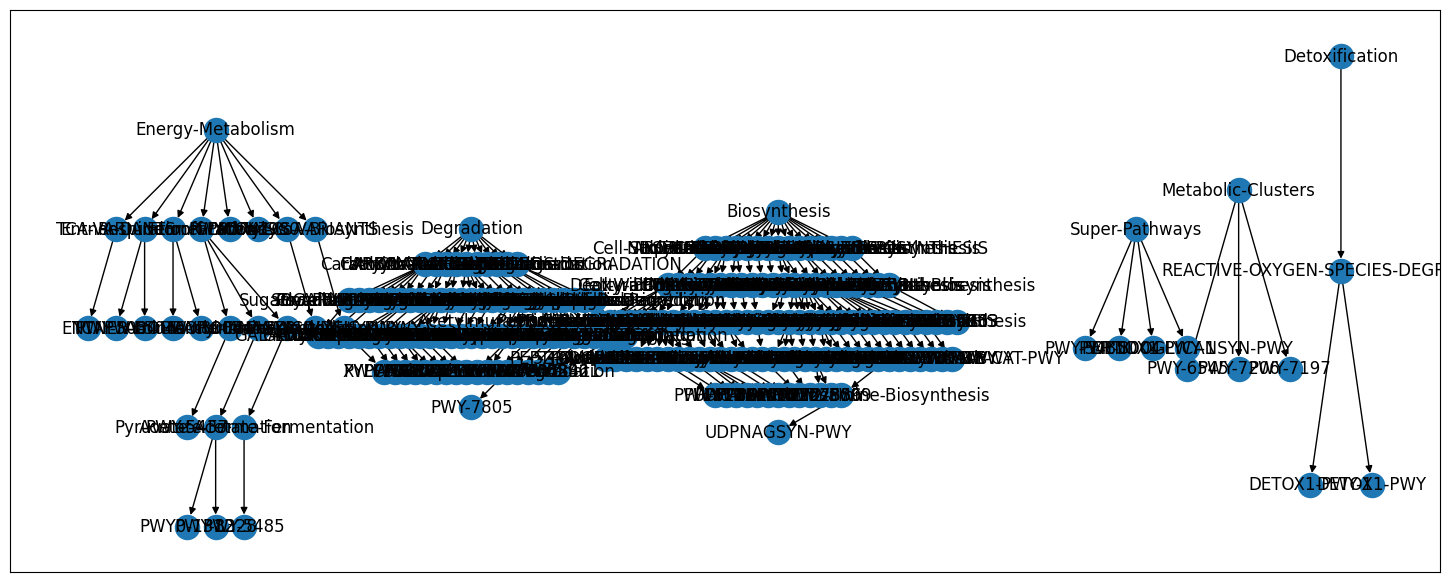

In [ ]:
from functools import reduce
from operator import add


fig, ax = plt.subplots()

G = ontologies["+/+"].graph

roots = next(nx.topological_generations(G))

offset = 0
for start in roots:
    layers = list(nx.bfs_layers(G, start))
    subgraph = G.subgraph(reduce(add, layers))

    nx.draw_networkx(subgraph,
                    nx.bfs_layout(subgraph,
                                  start,
                                  align="horizontal",
                                  scale = len(layers),
                                  center=(0, offset)),
                    ax=ax)
    offset += 2 * len(layers)

ax.invert_yaxis()
fig.tight_layout()
fig.set_size_inches(15, 6)